In [1]:
# ! pip install scipy
# ! pip install matplotlib
# ! pip install pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import cv2
from copy import deepcopy
from CarlaEnviornment import CarEnviornment 
from SAC_Agent import SoftActorCriticAgent
from SoftActorCritic import SACActor, SACCritic
from ReplayBuffer import ReplayBuffer
from Backbone import BackboneNetwork
from ModifiedTensorboard import ModifiedTensorBoard
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import Model, Input
from tensorflow.keras.models import save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2, inception_resnet_v2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
%load_ext tensorboard

pygame 2.0.1 (SDL 2.0.14, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
def linear_mapping(actions, max_brake_cmd, min_throttle_cmd):
    
    throttle, brake, steer = actions.numpy()[0]
    throttle, brake, steer = float(throttle), float(brake), float(steer)
    
    # Scale throttle linearly into the range min_throttle_cmd to 1 (from -1 to 1)
    throttle = (((1 - min_throttle_cmd)/2)* throttle) + (1 - (1 - min_throttle_cmd)/2)
    
    # Scale brake into the range 0 - max_brake_cmd (starts as -1 to 1)
    brake = (max_brake_cmd / 2)*brake + (max_brake_cmd/2)
    
    return throttle, brake, steer

In [5]:
def get_uniform_random_actions(max_brake_cmd=None, min_throttle_cmd=None):
    
    throttle = np.random.uniform(low=-0.25, high=1.0)
    steer = np.random.uniform(low=-1, high=1)
    
    time.sleep(0.02)
    
    return throttle, steer

In [6]:
def make_episode_stats_dict(add_extra_info, rolling): 
    
    episode_stats = {}
    episode_stats['reward_totals'] = []
    episode_stats['durations_sec'] = []
    episode_stats['enviornment_steps'] = []
    episode_stats[f'reward_totals_rolling_{rolling}'] = []
    episode_stats[f'durations_sec_rolling_{rolling}'] = []
    episode_stats[f'enviornment_steps_rolling_{rolling}'] = []
    episode_stats['total_enviornment_steps'] = []
    
    if add_extra_info:
        episode_stats['average_kph'] = []
        episode_stats['max_kph'] = []
        episode_stats['num_collisions'] = []
        episode_stats[f'average_kph_rolling_{rolling}'] = []
        episode_stats[f'max_kph_rolling_{rolling}'] = []
        episode_stats[f'num_collisions_rolling_{rolling}'] = []
    
    return episode_stats

In [7]:
def update_episode_stats_dict(episode_stats, episode_rewards, episode_start_time, episode_end_time, total_env_steps, episode_num, save_every_pd, extra_info, rolling): 
    
    episode_stats['reward_totals'].append(episode_rewards)
    episode_stats['durations_sec'].append(episode_end_time - episode_start_time)
    episode_stats[f'reward_totals_rolling_{rolling}'].append(np.mean(episode_stats['reward_totals'][-rolling:]))
    episode_stats[f'durations_sec_rolling_{rolling}'].append(np.mean(episode_stats['durations_sec'][-rolling:]))
    
    if len(episode_stats['enviornment_steps']) == 0:
        episode_stats['enviornment_steps'].append(total_env_steps)
        episode_stats['total_enviornment_steps'].append(total_env_steps)
        episode_stats[f'enviornment_steps_rolling_{rolling}'].append(total_env_steps)
    else:
        episode_stats['enviornment_steps'].append(total_env_steps - np.sum(episode_stats['enviornment_steps']))
        episode_stats['total_enviornment_steps'].append(total_env_steps)
        episode_stats[f'enviornment_steps_rolling_{rolling}'].append(np.mean(episode_stats['enviornment_steps'][-rolling:]))
        
    if extra_info is not None:
        avg_kph, max_kph, num_collisions = extra_info
        episode_stats['average_kph'].append(avg_kph)
        episode_stats['max_kph'].append(max_kph)
        episode_stats['num_collisions'].append(num_collisions)
        episode_stats[f'average_kph_rolling_{rolling}'].append(np.mean(episode_stats['max_kph'][-rolling:]))
        episode_stats[f'max_kph_rolling_{rolling}'].append(np.mean(episode_stats['average_kph'][-rolling:]))
        episode_stats[f'num_collisions_rolling_{rolling}'].append(np.mean(episode_stats['num_collisions'][-rolling:]))
    
    if episode_num % save_every_pd == 0:
        df = pd.DataFrame(episode_stats)
        df.to_csv(f"./episode_stats/episode_{episode_num}_{int(time.time())}.csv", index=False)
    
    return episode_stats

In [8]:
def print_episode_end_summary(episode_stats, episode_num, extra_info): 
    
    print(f"\n\n=================================Episode {episode_num} Summary=================================")
    print(f"Reward average (all episodes): {np.mean(episode_stats['reward_totals'])}")
    print(f"Reward (this episode): {episode_stats['reward_totals'][-1]}\n")
    print(f"Enviornment steps average (all episodes): {np.mean(episode_stats['enviornment_steps'])}")
    print(f"Enviornment steps (this episode): {episode_stats['enviornment_steps'][-1]}\n")
    print(f"Episode duration average (all episodes): {np.mean(episode_stats['durations_sec'])} seconds")
    print(f"Episode duration (this episode): {episode_stats['durations_sec'][-1]} seconds")
    if extra_info is not None: 
        print(f"\nAverage kph (this episode): {episode_stats['average_kph'][-1]}")
        print(f"Max kph (this episode): {episode_stats['max_kph'][-1]}")
        print(f"Num collisions (this episode): {episode_stats['num_collisions'][-1]}")
    print("======================================================================================\n")
    

In [9]:
def image_check(image):
    grayscale_image = cv2.cvtColor(image.astype('float32'), cv2.COLOR_BGR2GRAY)
    if cv2.countNonZero(grayscale_image) == 0:
        print("The image is black!")

In [10]:
def train_sac_agent(show_camera, img_width, img_height, max_seconds_per_episode, car_type, tau, gamma, convnet_type, actor_lr, critic_lr, max_buffer_size,
                    batch_size, alpha, start_steps, update_every, save_every, num_training_episodes, agent_verbose=False, verbose=False, print_every=10, get_extra_info=True,
                    save_every_pd=10, load_weights_paths=None, rolling_average_ep=50, batches_per_update=1, only_update_at_episode_end=False,
                    deterministic_episodes=None, let_critics_train_backbone=False, max_brake_cmd=1, min_throttle_cmd=0): 
    
    env = CarEnviornment(show_camera=show_camera,                          # Determines the current image from the cars camera should be displayed.
                         img_width=img_width,
                         img_height=img_height,     
                         max_seconds_per_episode=max_seconds_per_episode,
                         send_extra_info=get_extra_info)
    
    
    agent = SoftActorCriticAgent(tau=tau,                           # Smoothing Coef for Polyak averaging of target networks.
                                 gamma=gamma,                       # Constant for future reward discounting
                                 convnet_type=convnet_type,         # Determines what convolutional backbone network should be used
                                 actor_lr=actor_lr,                 # Learning rate for actor and convnet backbone networks
                                 critic_lr=critic_lr,               # Learning rate for critic networks
                                 max_buffer_size=max_buffer_size,   # Max number of experiences to store in replay buffer (set based on available memory).
                                 batch_size=batch_size,             # Number of experiences to pull from replay buffer during each training round.
                                 convnet_input_shape=(img_height, img_width, 3),
                                 verbose=agent_verbose,
                                 load_weights_paths=load_weights_paths,
                                 critics_train_conv=let_critics_train_backbone,
                                 alpha=alpha)                       # Temperature parameter for SAC policy loss. Determines entropy components contribution
                                                                    # to the loss. The larger alpha is, more exploration (and less exploitation) there will be. 
        
    episode_stats = make_episode_stats_dict(add_extra_info=get_extra_info, rolling=rolling_average_ep)
    current_state = env.reset()
    image_check(current_state)
    enviornment_steps = 0
    done=False
    
    for episode_number in tqdm(range(1, num_training_episodes + 1), ascii=True, unit="episodes"):
        
        agent.tensorboard.step = episode_number
        episode_start_time = time.time()
        episode_reward_total = 0.0
        
        episode_throttle_cmds = []
        #pisode_brake_cmds = []
        episode_steer_cmds = []
        
        # While we have not recieved the done flag from the enviornment. 
        while not done:

            # Increment counter for total number of steps taken in the enviornment (across all episodes)
            enviornment_steps+=1
        
            # Trick to improve exploration. For some number of steps at the very start of training, the
            # agent takes actions uniformly at random. After that, the agent starts normal SAC exploration.
            if episode_number <= start_steps and episode_number not in deterministic_episodes:

                throttle, steer = get_uniform_random_actions()
            
                next_state, reward, done, extra_info = env.step(action=(throttle, steer))
                
                agent.update_replay_buffer(state=current_state, action=(throttle, steer),
                                           reward=reward, new_state=next_state, done=done)
                
                current_state = next_state
                episode_reward_total += reward

            else:
                
                preprocessed_current_state = agent.convnet_backbone(state=current_state.reshape(1, img_height, img_width, 3),
                                                                    preprocess=True)
                
                # 1. Observe state s and select action
                mean_actions, sampled_actions, logprob = agent.actor_network(preprocessed_current_state)
                
                if episode_number in deterministic_episodes:
                    throttle, steer = mean_actions.numpy()[0]
                    throttle = float(throttle)
                    steer = float(steer)
                else:
                    throttle, steer = sampled_actions.numpy()[0]
                    throttle = float(throttle)
                    steer = float(steer)
                    
                
                
                # 2. Perform action and get response back from enviornment. 
                next_state, reward, done, extra_info = env.step(action=(throttle, steer))
                
                # 3. Add new transition to replay buffer.
                agent.update_replay_buffer(state=current_state, action=(throttle, steer),
                                           reward=reward, new_state=next_state, done=done)
            
                episode_reward_total += reward
                current_state = next_state
            
            
            episode_throttle_cmds.append(throttle)
            #pisode_brake_cmds.append(brake)
            episode_steer_cmds.append(steer)
            
            # Perform Actor, Critic, and Target network weight updates. 
            if enviornment_steps >= start_steps and enviornment_steps % update_every == 0 and not done and not only_update_at_episode_end:
                agent.update_policy_and_qvalue_networks()
        
        
        #==================================================
        # At the end of each episode 
        #==================================================
        
        episode_end_time = time.time()
        
        #print(f"before actor destruction: {enviornment_steps}, episode: {episode_number}")
        for actor in env.actor_list:    # Remove all the actors from the enviornment
                actor.destroy()
                
        if only_update_at_episode_end:
            for batch_update in range(batches_per_update):
                agent.update_policy_and_qvalue_networks()
                
        episode_stats = update_episode_stats_dict(episode_stats=episode_stats, episode_rewards=episode_reward_total, episode_start_time=episode_start_time,
                                                  episode_end_time=episode_end_time, total_env_steps=enviornment_steps, episode_num=episode_number, save_every_pd=save_every_pd,
                                                  extra_info=extra_info, rolling=rolling_average_ep)
        

        network_losses = agent.get_loss_trackers()
        
        agent.tensorboard.update_stats(reward_total=episode_stats['reward_totals'][-1], duration=episode_stats['durations_sec'][-1],
                                       episode_steps=episode_stats['enviornment_steps'][-1], episode_avg_kph=episode_stats['average_kph'][-1],
                                       episode_collisions=episode_stats['num_collisions'][-1], episode_max_kph=episode_stats['max_kph'][-1],
                                       reward_total_rolling=episode_stats[f'reward_totals_rolling_{rolling_average_ep}'][-1],
                                       duration_rolling=episode_stats[f'durations_sec_rolling_{rolling_average_ep}'][-1],
                                       episode_steps_rolling=episode_stats[f'enviornment_steps_rolling_{rolling_average_ep}'][-1],
                                       episode_avg_kph_rolling=episode_stats[f'average_kph_rolling_{rolling_average_ep}'][-1],
                                       episode_max_kph_rolling=episode_stats[f'max_kph_rolling_{rolling_average_ep}'][-1],
                                       episode_collisions_rolling=episode_stats[f'num_collisions_rolling_{rolling_average_ep}'][-1],
                                       avg_policy_loss=np.mean(network_losses['policy_loss']), num_policy_updates=len(network_losses['policy_loss']),
                                       avg_critic1_loss=np.mean(network_losses['critic1_loss']), num_critic1_updates=len(network_losses['critic1_loss']),
                                       avg_critic2_loss=np.mean(network_losses['critic2_loss']), num_critic2_updates=len(network_losses['critic2_loss']),
                                       avg_combined_critic_loss=np.mean(network_losses['total_critic_loss']),
                                       min_policy_loss=np.min(network_losses['policy_loss']), max_policy_loss=np.max(network_losses['policy_loss']),
                                       min_critic1_loss=np.min(network_losses['critic1_loss']), max_critic1_loss=np.max(network_losses['critic1_loss']),
                                       min_critic2_loss=np.min(network_losses['critic2_loss']), max_critic2_loss=np.max(network_losses['critic2_loss']),
                                       min_combined_critic_loss=np.min(network_losses['total_critic_loss']),
                                       max_combined_critic_loss=np.max(network_losses['total_critic_loss']),
                                       avg_throttle=np.mean(episode_throttle_cmds), avg_steer=np.mean(episode_steer_cmds))
        
        #print(f"after tb, before print: {enviornment_steps}, episode: {episode_number}")
        if verbose and episode_number % print_every == 0:
            print_episode_end_summary(episode_stats, episode_number, extra_info)
        
        #print(f"after print, before save: {enviornment_steps}, episode: {episode_number}")
        if episode_number % save_every == 0:
            if verbose:
                print("Saving models...\n")
            agent.save_all_models()
        
        done = False
        agent.reset_loss_trackers()
        current_state = env.reset()
        
    return agent

In [11]:
if __name__ == "__main__":
    
    agent = train_sac_agent(show_camera=False,                  # Display a real-time view of the cars camera
                            img_width=400,                      # Width of cars camera image in pixels.
                            img_height=200,                     # Height of cars camera image in pixels.
                            max_seconds_per_episode=45,         # Episode ends when car crashes, or after this many seconds has elapsed.
                            car_type="Cybertruck",              # Choice of vehicle for the agent.
                            tau=0.005,                          # Smoothing parameter for polyak averaging of target networks.
                            gamma=0.99,                         # Constant to discount future rewards when calculating state-action values.
                            convnet_type=None,                  # Not yet implemented, parameter to allow switching convnet backbone type.
                            actor_lr=3e-5,                      # Learning rate for actor and convnet backbone networks.
                            critic_lr=3e-5,                     # Learning rate for both critic networks.
                            max_buffer_size=7_000,              # Max number of memories (past experiences) to hold and learn from. Choose based on avail memory. 
                            batch_size=16,                      # Number of experiences to pull from buffer and train on at each training iteration
                            alpha=0.4,                          # Temperature parameter. Controls policy loss entropy. (larger value is more exploration). 
                            start_steps=20,                     # Number of EPISODES with actions taken uniformly at random before starting SAC style exploration.
                            save_every=100,                     # Number of EPISODES between model saves. (All six networks get saved). 
                            update_every=1,                     # Number of STEPS (Actions) between performing a gradient descent step. (ignored if only_update_at_episode_end)
                            num_training_episodes=350,          # Total number of episodes to train for. 
                            agent_verbose=False,                # Print network weight updates as they happen. (Usually better to leave as False). 
                            verbose=False,                      # Controls any other optional printing inside the training loop. 
                            print_every=1,                      # Number of episodes elaposed between printing updates to the console.
                            save_every_pd=50,                   # Number of episodes between saving some of the data to a pandas dataframe
                            load_weights_paths=None,            # If we want to load weights from a previous run to continue training
                            rolling_average_ep=50,              # Look back period to create rolling averages for some statistics. (number of episodes).
                            batches_per_update=100,             # Number of batches to sample from the replay buffer and train on at each iteration
                            only_update_at_episode_end=True,    # If we want to update only at the end of episodes (rather than during). This allows for faster control of vehicle if training is slow.
                            deterministic_episodes = list(range(300, 350)),  # Instead of sampling fro action distribution (explore), we can select the mean and see how the policy performs (after some training). 
                            let_critics_train_backbone=True,                 # Whether or not the critic networks error signal should be allowed to propagate back to the convolutional backbone.  
                            max_brake_cmd=None,                          # Obsolete parameters, previously used brake and throttle were their own commands, and linear mapping was used
                            min_throttle_cmd=None)                       # to convert the -1 to 1 (tanh) output to 0 to 1 throttle and brake commands. It was found that any small amount of braking
                                                                         # completely cancels all throttle, which led to combining the commands and using a -1 to 1 range, where the bottom half is for brake. 

100%|##############################| 350/350 [17:56:36<00:00, 184.56s/episodes]


###### os.listdir("./logs/SAC/")

In [12]:
#%reload_ext tensorboard

In [13]:
#%tensorboard --logdir=./logs/SAC/ --port=6006

In [14]:
'''
load_weights = {'critic1' : './models/critic1/critic1_2021_08_14-13_24_09.ckpt',
                'critic2': './modls/critic2/critic2_2021_08_14-13_24_09.ckpt',
                'actor':'./models/actor/actor_2021_08_14-13_24_09.ckpt',
                'critic1_target' : './models/critic1_target/critic1_target_2021_08_14-13_24_09.ckpt',
                'critic2_target' : './models/critic2_target/critic2_target_2021_08_14-13_24_09.ckpt',
                'backbone': "./models/backbone/backbone_2021_08_14-13_24_09.ckpt"}
''';

In [15]:
def review_agents_memory(agent, num_images=5, vertical_stack=5):
    
    memory = agent.replay_buffer.state_memory
    
    idxs = np.random.randint(low=0, high=len(memory)-vertical_stack, size=(num_images))
    
    fig, axs = plt.subplots(nrows=vertical_stack, ncols=num_images, figsize=(20, 3*vertical_stack))
     
    for index, idx in enumerate(idxs):
        for sequential_memory_num in range(0, vertical_stack):
            axs[sequential_memory_num][index].imshow(memory[idx + sequential_memory_num] / 255.0)
            grayscale_image = cv2.cvtColor(memory[idx + sequential_memory_num].astype('float32'), cv2.COLOR_BGR2GRAY)
            num_nonzero_pixels = cv2.countNonZero(grayscale_image)
            axs[sequential_memory_num][index].set_title(f"""Memory {idx + sequential_memory_num}\nshape:{memory[idx + sequential_memory_num].shape}\nnum_nonzero: {num_nonzero_pixels}""")
    
    plt.tight_layout()

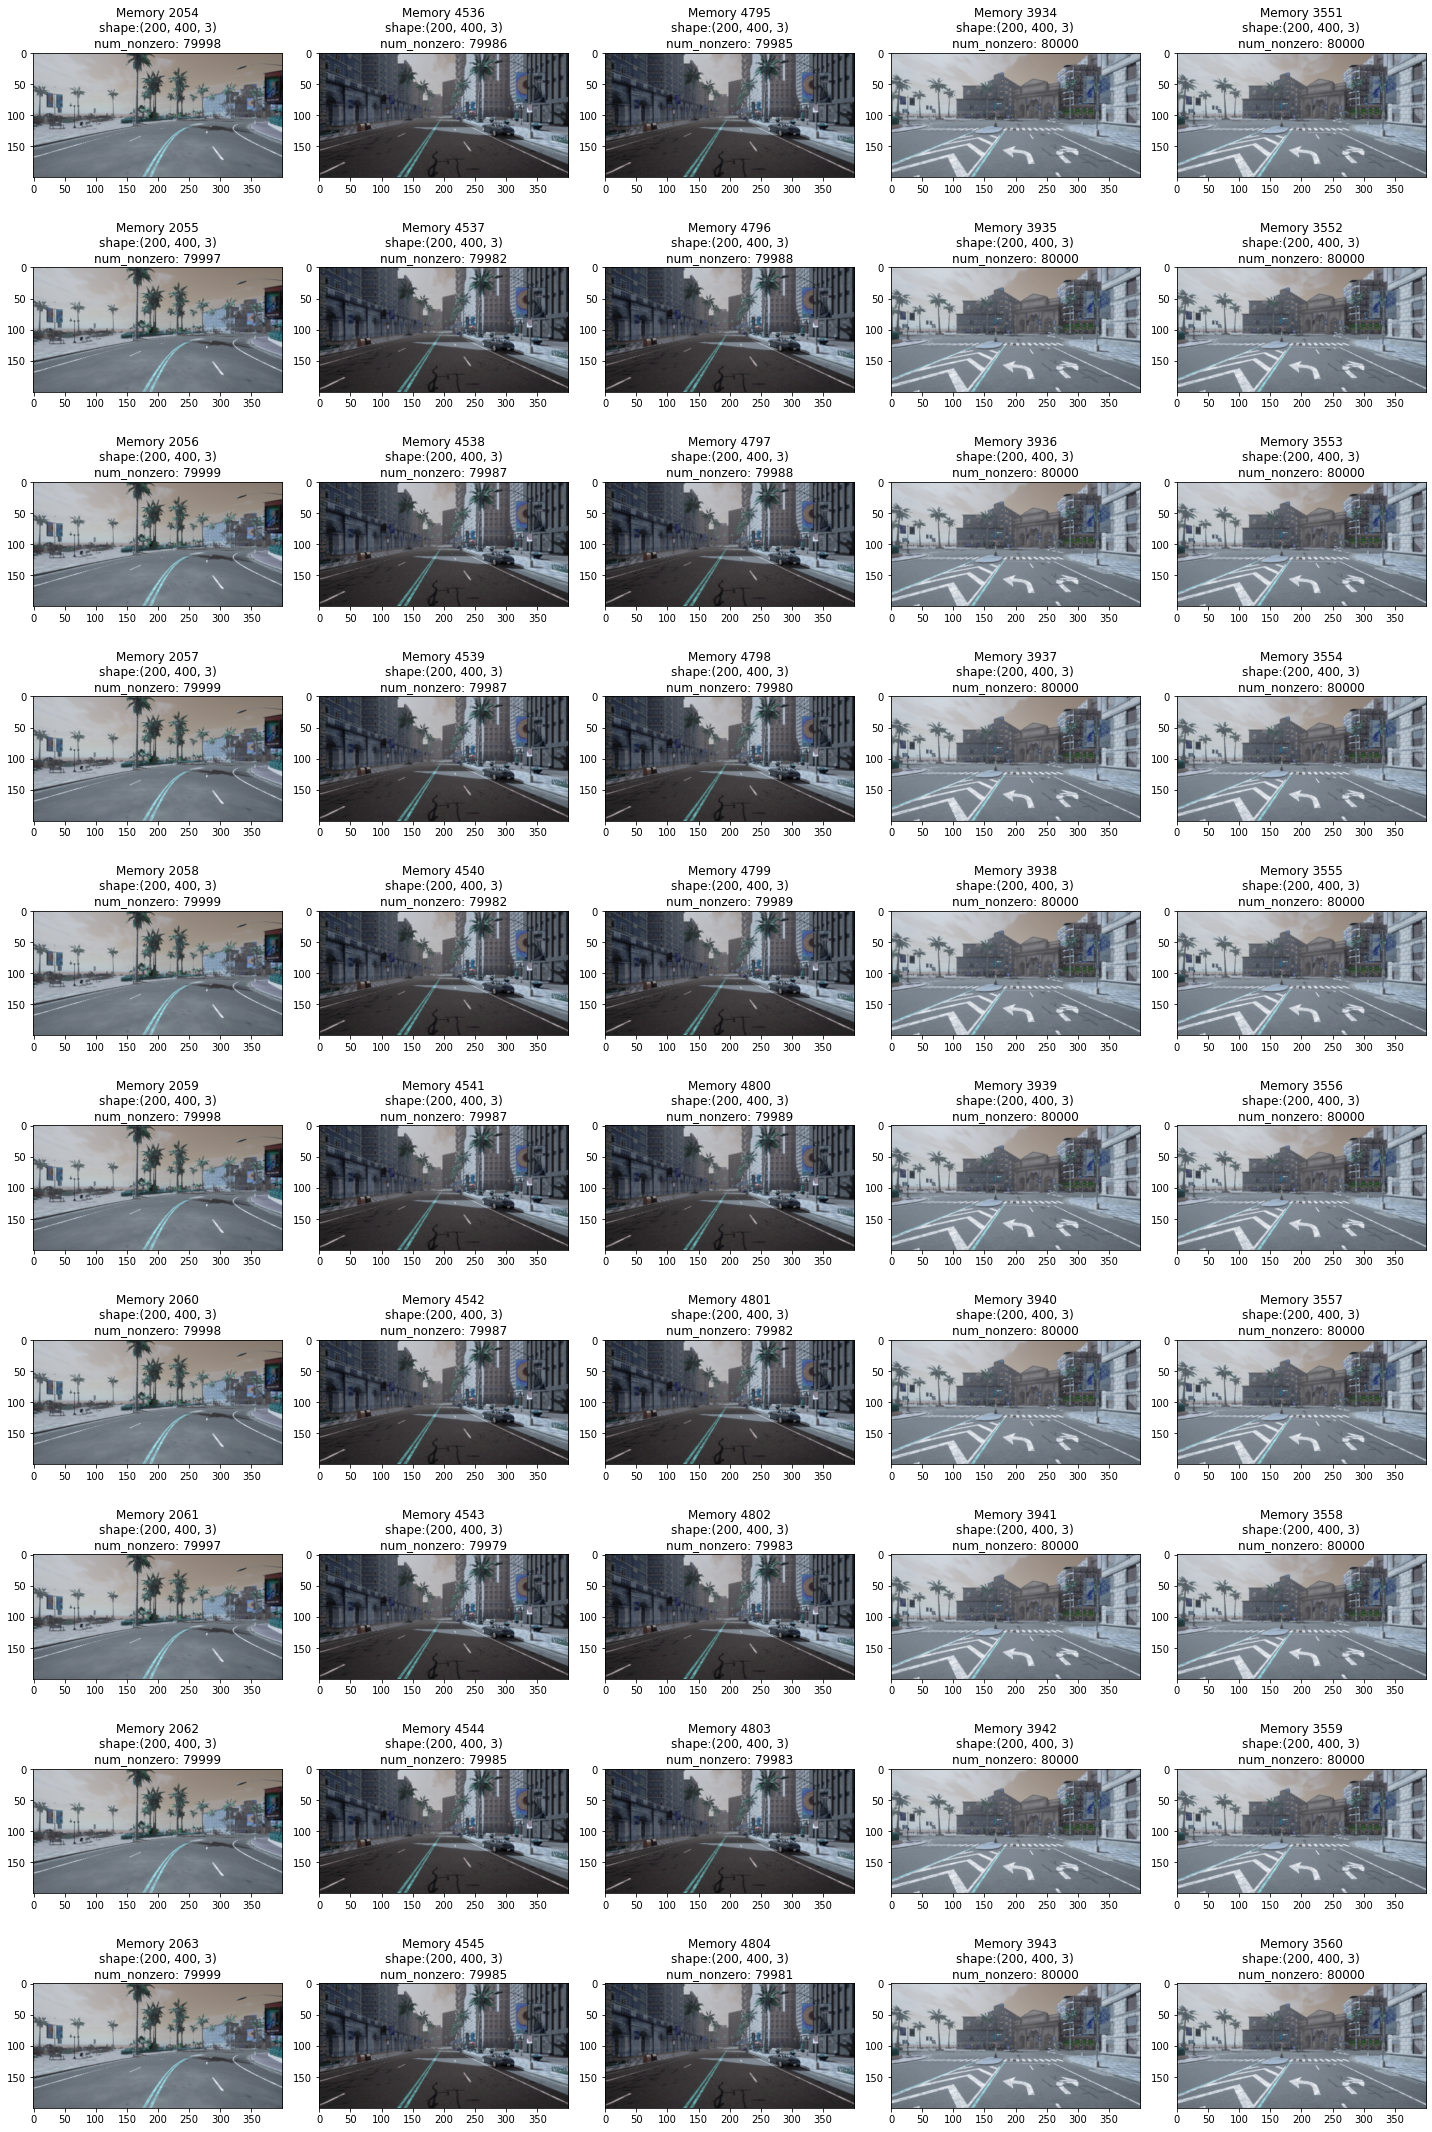

In [16]:
review_agents_memory(agent, num_images=5, vertical_stack=10)